In [21]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import gmaps
from plotly.offline import iplot,init_notebook_mode#import plotly.plotly as py--offline mode
init_notebook_mode()
from plotly import tools
import plotly.graph_objs as go # Importing high level chart objects
import plotly.figure_factory as ff
import plotly.plotly as py
%matplotlib inline
from pprint import pprint
from us import states


ModuleNotFoundError: No module named 'us'

## Electric Charging Station Data
- NREL API for Alternative Fuel Stations https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/

In [3]:

NREL_api = 'eQoxM6xdGyjEOe7V6yaeXnvHhUEGnCqucDxdh6dE'

nrel_url = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.json?'

#parameters limit type of fuel station (ELEC)
params = {'api_key' : NREL_api, 'fuel_type' : 'ELEC', 'access': 'all','state': ''}

#fields wanted for data set
open_dates = []
station_type = []
lat = []
lng = []
state_name = []

#loop for API calls - using US python library to loop through states (appreviations required by API format)
for s in range(len(states.STATES)):
    params.update({'state': states.STATES[s].abbr})
    alt_stations = requests.get(nrel_url, params).json()      
    for r in range(len(alt_stations['fuel_stations'])):
                   if alt_stations['fuel_stations'][r]['open_date'] is not None:
                       open_dates.append(alt_stations['fuel_stations'][r]['open_date'])
                       station_type.append(alt_stations['fuel_stations'][r]['access_code'])
                       lat.append(alt_stations['fuel_stations'][r]['latitude'])
                       lng.append(alt_stations['fuel_stations'][r]['longitude'])
                       state_name.append(alt_stations['fuel_stations'][r]['state'])
          


['2011-03-15', '2011-03-15', '2011-03-15', '2011-03-15', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2011-09-26', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2012-01-31', '2011-03-15', '2011-03-15', '2011-03-15', '2011-03-15', '2012-10-25', '2012-10-25', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01', '2014-02-01', '2014-02-01', '2014-03-19', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015-04-01', '2015

In [4]:
#Combine lists into DataFrame and Export
elec_stationDF = pd.DataFrame({'Date_Opened':open_dates, 'Access_Type':station_type, 'Lat':lat, 'Lng':lng,'State':state_name})


elec_stationDF.to_csv('Datasets\Elec_StationsbyState_Year')
elec_stationDF.head()

Date_Opened Access_Type        Lat        Lng State
0  2011-03-15      public  33.394903 -86.807186    AL
1  2011-03-15      public  30.660697 -87.858464    AL
2  2011-03-15      public  34.563857 -86.972193    AL
3  2011-03-15      public  32.377023 -86.208535    AL
4  2012-01-31      public  34.290864 -86.244855    AL

In [ ]:
#The Date Data was formatted as a string- I just needed the year, so I looped
#through the data to trim the date and turn it into an integer value

Date = []
for n in elec_stationDF['Date_Opened']:
    t = n[:-6]
    Date.append(int(t))

elec_stationDF2 = pd.DataFrame({"Date":Date, "Lat":elec_stationDF['Lat'],'Lng':elec_stationDF['Lng'],'State':elec_stationDF['State']})

#Removed data for DC (Sorry DC you are not technically a state), and for the year 2019
elec_stationDF2 = elec_stationDF2.loc[elec_stationDF2['Date']!=2019,:]
elec_stationDF2 = elec_stationDF2.loc[elec_stationDF2['State']!='DC',:]
elec_stationDF2.head()

In [ ]:
#create plot that shows trajectary of stations opened in the us over time

stations_yearsGB = elec_stationDF2.groupby('Date').aggregate({'State':'count'})

fig = stations_yearsGB.plot(legend = False, xlim = (2005,2018),xticks = stations_yearsGB.index)

fig.set_title('Electric Charging Stations Opened in the US (2005 to 2018)')
fig.set_ylabel('Number of Charging Stations')
fig.grid(alpha = .25)

fig = fig.get_figure()
fig.savefig('Plots and Maps\Electric Charging Stations 2005 to 2018')

In [ ]:
#Plot of charging stations by state to map against the incentive data

stations_statesGB = stations_years.groupby('State').aggregate({'Date':'count'})

fig2 = stations_statesGB.plot(kind = 'bar',figsize = (50,20),fontsize = 30,rot = 30,stacked = True,legend = False)
fig2.set_xlabel('State', fontsize = 50)
fig2.set_ylabel('Charging Stations',fontsize = 50)
fig2.set_title('Total Charging Stations by State',fontsize = 50)

fig2 = fig2.get_figure()
fig2.savefig('Plots and Maps\Total Charging Stations by State')

In [ ]:
#export station data to csv
stations_statesGB.to_csv('Datasets\Stationstomergewithincentives.csv')

## Google Heatmap
## But seriously don't run this a billion times.

##Create google map with density of location of stations in US.

gmaps.configure(api_key=gmaps_api)

locations = stations_years[['Lat','Lng']].astype(float)
figMAP = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations)
heat_layer.dissipating = False
heat_layer.max_intensity = 100
heat_layer.point_radius = 1
figMAP.add_layer(heat_layer)
figMAP

##Tax and Incentive Data 
- Includes both state and federal data, but we focused on States
- NREL API for Transportation Laws and Incentives https://developer.nrel.gov/docs/transportation/transportation-incentives-laws-v1/

In [5]:
#Using the parameters function in the get request threw errors, so I just wrote out
#the url. There was only one call made for this set of data.
#Parameters were it had to be an incentive for Plug-in, Hybrid, or electric infrastructure
#and there had to be provisions in the incentive/law for individual owners.

nrel_incentiveURL= "https://developer.nrel.gov/api/transportation-incentives-laws/v1.json?api_key=eQoxM6xdGyjEOe7V6yaeXnvHhUEGnCqucDxdh6dE&technology=ELEC%2CHEV%2CPHEV&user_type=IND&poc=false&local=false"


response = requests.get(nrel_incentiveURL).json()
pprint(response)

{'inputs': {'local': 'false',
            'poc': 'false',
            'technology': 'ELEC,HEV,PHEV',
            'user_type': 'IND'},
 'metadata': {'count': 248, 'version': '1.0.0'},
 'result': [{'agency': 'U.S. Department of Energy',
             'amended_date': None,
             'categories': [{'category_type': 'tech',
                             'code': 'AFTMKTCONV',
                             'title': 'Aftermarket Conversions'},
                            {'category_type': 'user',
                             'code': 'MAN',
                             'title': 'AFV Manufacturer/Retrofitter'},
                            {'category_type': 'user',
                             'code': 'AFS',
                             'title': 'Alternative Fuel Dealer'},
                            {'category_type': 'user',
                             'code': 'AFP',
                             'title': 'Alternative Fuel Producer'},
                            {'category_type': 'user',
      

In [15]:
#cyle through the data to pull relevant fields

enacted_date = []
state_name = []
title = []
incentive_type =[]
amended_date =[]
significant_update_date =[]

for r in range(len(response['result'])):
    amended_date.append(response['result'][r]['amended_date'])
    significant_update_date.append(response['result'][r]['significant_update_date'])
    enacted_date.append(response['result'][r]['enacted_date'])
    state_name.append(response['result'][r]['state'])
    title.append(response['result'][r]['title'])
    incentive_type.append(response['result'][r]['type'])

#combine lists to dataframe and export.
    
incentivesDF = pd.DataFrame({'title':title,'incentive_type':incentive_type,'state_name':state_name,'enacted_date':enacted_date,'amended_date':amended_date,'significant_update_date':significant_update_date})
incentivesDF.head()
incentivesDF.to_csv('Datasets\IncentiveData')

In [16]:
#There were three dates included in the data, but not all entries had all three (or any)
#First, drop rows that have no dates
incentivesDF = incentivesDF.dropna(thresh = 4)
#Second, drop federal incentive data
incentivesDF = incentivesDF.loc[incentivesDF['state_name']!='US',:]


In [17]:
# Because not all entries had an enacted date, I cycled through to find the 
#earliest date available for the law/incentive. Each date also had to be 
#foratted from a string into an integer value. 

en_Date = []
for n in incentivesDF['enacted_date']:
    if isinstance(n, str) == True:
        t = n[:-16]
        en_Date.append(int(t))
    else:
        en_Date.append(2222) 

am_Date = []
for n in incentivesDF['amended_date']:
    if isinstance(n, str) == True:
        t = n[:-16]
        am_Date.append(int(t))
    else:
        am_Date.append(2222)

sig_Date = []
for n in incentivesDF['significant_update_date']:
    if isinstance(n, str) == True:
        t = n[(len(n)-4):]
        sig_Date.append(int(t))
    else:
        sig_Date.append(2222)

#compare the Date values and pick the earliest to add to list "Date"
Date = []
for d in range(len(sig_Date)):
    if sig_Date[d] < am_Date[d] and en_Date[d]:
        Date.append(sig_Date[d])
    elif am_Date[d] < en_Date[d]:
        Date.append(am_Date[d])
    else:
        Date.append(en_Date[d])

In [18]:
#Create new dataframe with formatted dates
incentive_DF = pd.DataFrame({'Title':incentivesDF['title'],'Incentive Type':incentivesDF['incentive_type'],'State or Federal':incentivesDF['state_name'],'Date':Date})

incentive_DF.head()

Title  \
4  Alternative Fuel Vehicle (AFV) and Energy Effi...   
5  Alternative Fuel Vehicle Emissions Test Exemption   
6  Reduced Alternative Fuel Vehicle (AFV) License...   
7  Plug-In Electric Vehicle (PEV) Charging Rate R...   
8  Alternative Fuel Vehicle (AFV) Weight Limit Ex...   

               Incentive Type State or Federal  Date  
4            State Incentives               AZ  2009  
5            State Incentives               AZ  2015  
6            State Incentives               AZ  2018  
7  Utility/Private Incentives               CA  2018  
8            State Incentives               CO  2016

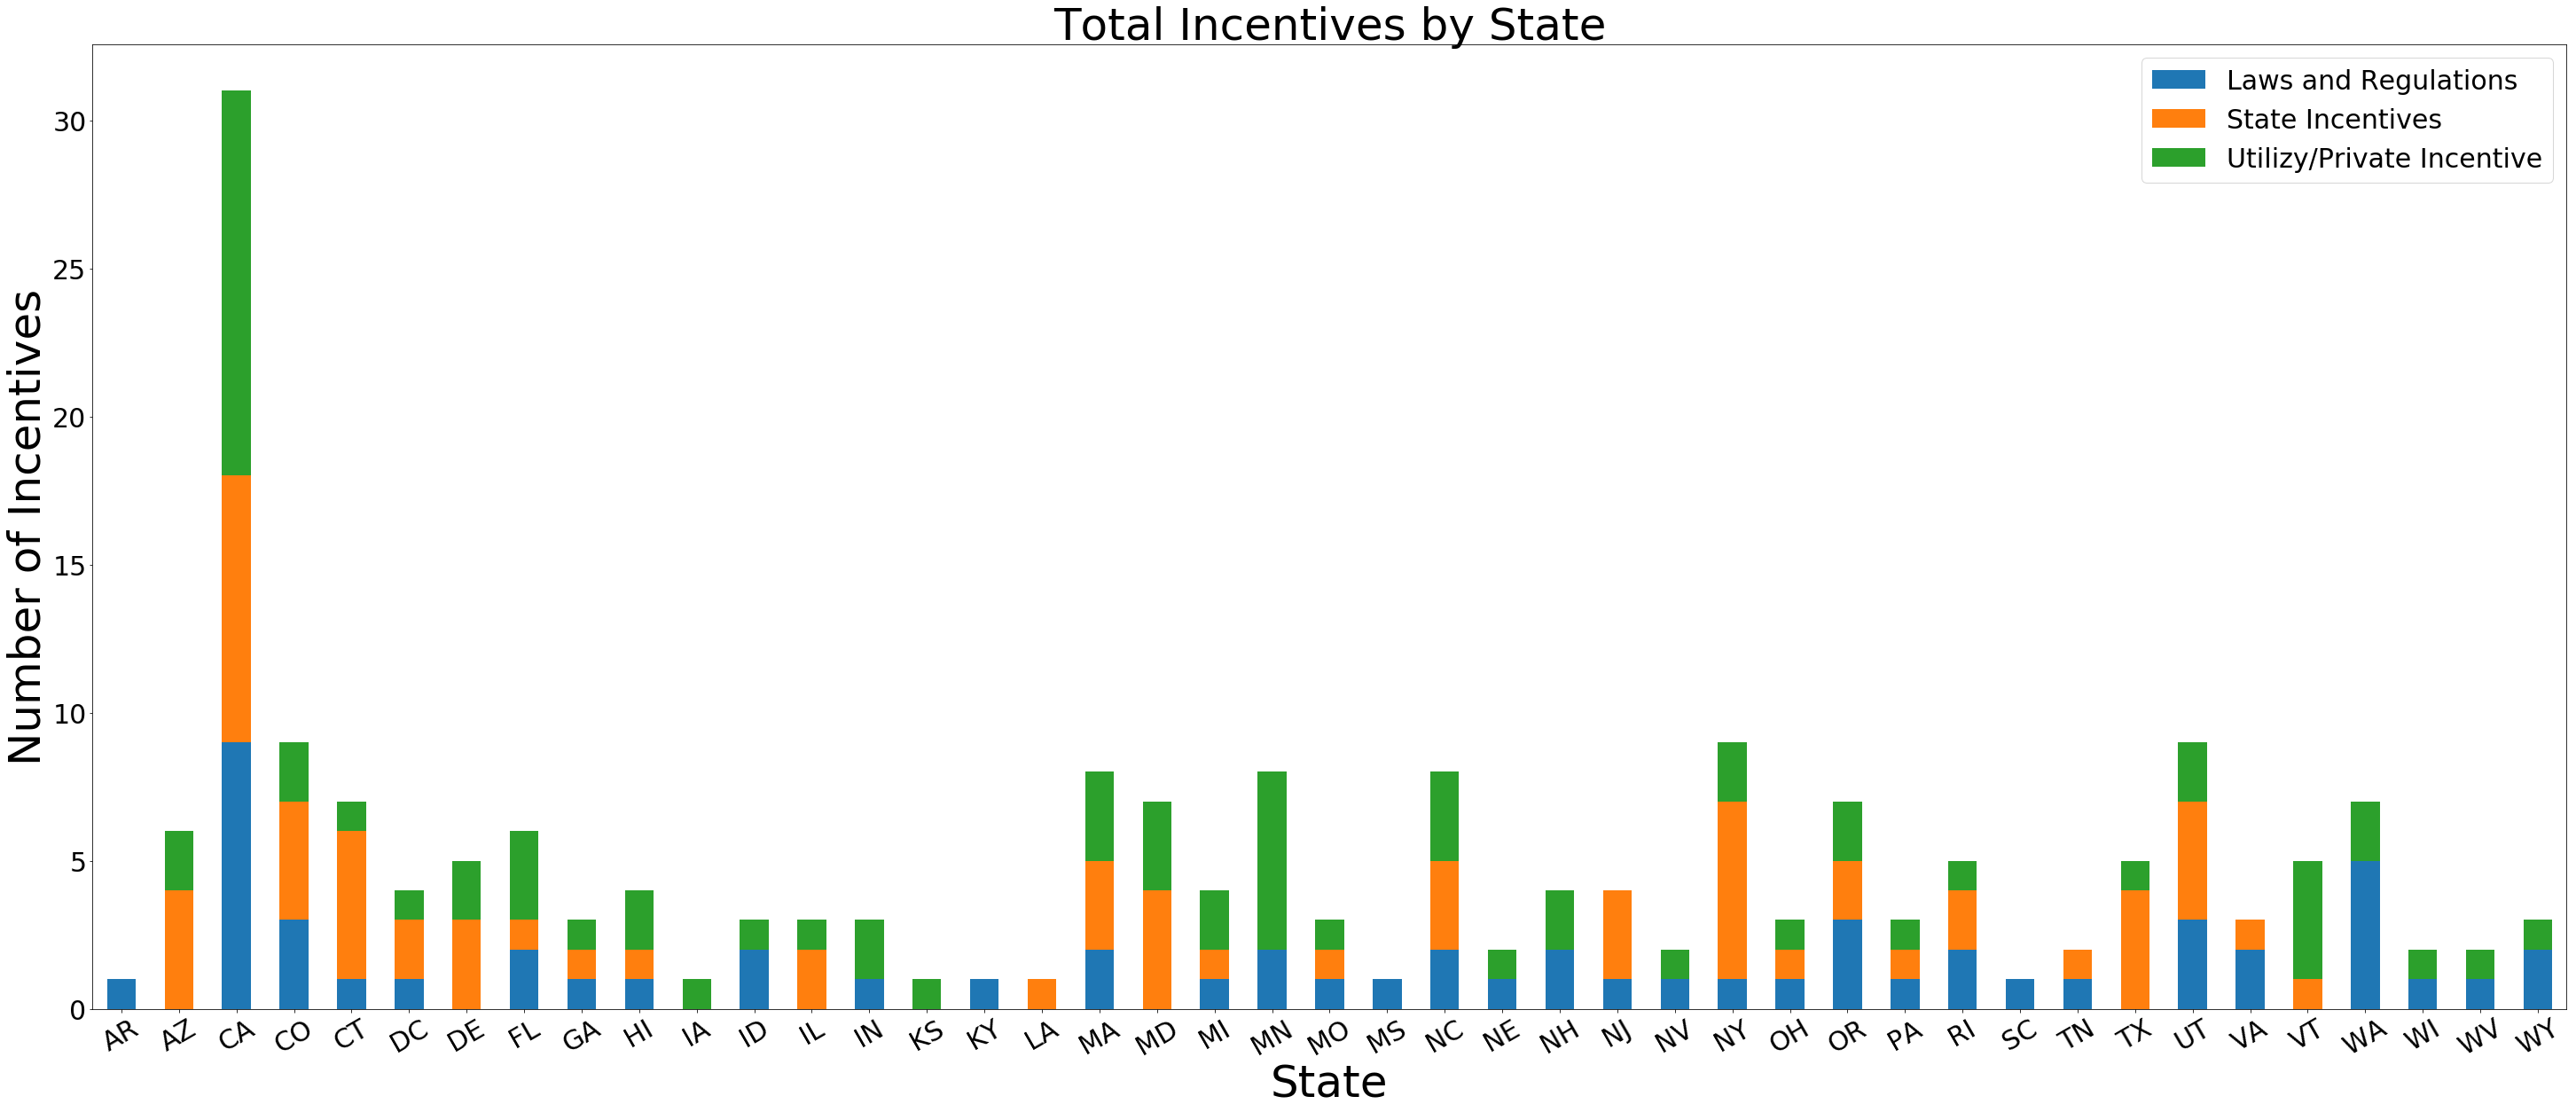

In [19]:
#create stacked bar chart showing how many incentives were available in each state, by type

incentive_GBType = incentive_DF.groupby(['Incentive Type']).aggregate({'Date':'count'})
incentive_GBState = incentive_DF.groupby(['State or Federal','Incentive Type']).aggregate({'Date':'count'})

fig2 = incentive_GBState.unstack().plot(kind = 'bar',figsize = (50,20),fontsize = 30,rot = 30,stacked = True)
fig2.set_xlabel('State', fontsize = 50)
fig2.set_ylabel('Number of Incentives',fontsize = 50)
fig2.set_title('Total Incentives by State',fontsize = 50)
fig2.legend(('Laws and Regulations','State Incentives','Utilizy/Private Incentive'),fontsize = 30)
fig2 = fig2.get_figure()
fig2.savefig('Plots and Maps\Total Incentives by State')


In [21]:
incentive_Time = incentive_DF.groupby("Date").aggregate({'Title':'count'})
incentive_Time.head()

Title
Date       
1993      3
1995      1
1996      1
1997      1
1998      1

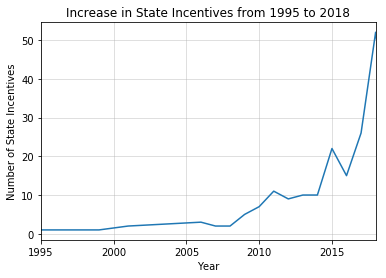

In [26]:
fig4 = incentive_Time.plot(kind = 'line', xlim = (1995,2018),legend = False)
fig4.set_xlabel('Year')
fig4.set_ylabel('Number of State Incentives')
fig4.set_title('Increase in State Incentives from 1995 to 2018')
fig4.grid(alpha = .5)
fig4 = fig4.get_figure()
fig4.savefig('Plots and Maps\Increase in State Incentives 1995 to 2018')

In [ ]:
#merge station data with incentive data
stations= pd.read_csv('Datasets\Stationstomergewithincentives.csv')

stations = stations.rename(columns = {'Date':'Stations'})
incentive_DF = incentive_DF.rename(columns = {'State or Federal':'State'})
incentives = incentive_DF.groupby(['State']).aggregate({'Date':'count'})


In [ ]:
#merge the data 

merged_data = stations.merge(incentives, how = 'outer', on = 'State' )
merged_data = merged_data.fillna(0)
merged_data = merged_data.loc[merged_data['State']!='DC',:]
merged_data = merged_data.rename(columns = {'Date':'Incentives'})
merged_data['Stations By 10%'] = merged_data['Stations']*0.1


In [ ]:
#plot the data
figdata = merged_data.groupby(['State']).aggregate({'Incentives': 'sum','Stations By 10%':'sum'})
fig3 = figdata.plot(kind = 'bar', ylim = (0,50),figsize = (50,20),fontsize = 30,rot = 30)
fig3.legend(('Incentives','Charging Stations'),fontsize = 30,loc = 'best')
fig3.set_xlabel('State',fontsize = 30)
fig3.set_ylabel('Number of Stations and Incentives\n (Station Data reduced by 10% for visualization purposes)',fontsize = 30)
fig3.set_title('Total Number of Incentives vs Number of Electric Charging Stations per State',fontsize = 30)

fig3 = fig3.get_figure()
fig3.savefig('Plots and Maps\Incentives V Charging Stations')


## Sales data by model
- Excel docs were separate by type (Hybrid vs. Plug In) @  https://afdc.energy.gov/data/10567
- Combined manually in Excel and then imported for further cleaning.


In [7]:
#Import the data and replace NAN with 0 (NaN represented no sales in that year)
salesdatabymodel = pd.read_excel('Datasets/SalesByModel_Updated4.6.xlsx')

salesdatabymodel = salesdatabymodel.fillna(0)
salesdatabymodel.head()

Maker      Model Type  1999  2000  2001  2002  2003  2004  2005   ...    \
0  Acura        MDX  HEV   0.0   0.0   0.0   0.0   0.0   0.0   0.0   ...     
1  Acura        RLX  HEV   0.0   0.0   0.0   0.0   0.0   0.0   0.0   ...     
2  Acura        NSX  HEV   0.0   0.0   0.0   0.0   0.0   0.0   0.0   ...     
3  Acura        ILX  HEV   0.0   0.0   0.0   0.0   0.0   0.0   0.0   ...     
4   Audi  Q5 Hybrid  HEV   0.0   0.0   0.0   0.0   0.0   0.0   0.0   ...     

   2008  2009  2010  2011   2012    2013   2014   2015   2016    2017  
0   0.0   0.0   0.0   0.0    0.0     0.0    0.0    0.0    0.0  1807.0  
1   0.0   0.0   0.0   0.0    0.0     0.0  133.0  250.0  199.0   292.0  
2   0.0   0.0   0.0   0.0    0.0     0.0    0.0    0.0  267.0   581.0  
3   0.0   0.0   0.0   0.0  972.0  1461.0  379.0   22.0    1.0     0.0  
4   0.0   0.0   0.0   0.0  270.0   854.0  283.0   97.0   18.0     0.0  

[5 rows x 22 columns]

In [11]:
#For easier data manipulation, I grouped the data frame by type/maker/model
#and then stacked the year columns to create one single column for years.


sdGB = salesdatabymodel.groupby(['Type','Maker','Model']).mean()

sdGB = sdGB.stack()


sdGB.index.set_names('Years',level=len(sdGB.index.names)-1, inplace=True)
sdGB =sdGB.reset_index().rename(columns={0:'Sales'})
sdGB.head()

Type  Maker Model  Years  Sales
0  HEV  Acura   ILX   1999    0.0
1  HEV  Acura   ILX   2000    0.0
2  HEV  Acura   ILX   2001    0.0
3  HEV  Acura   ILX   2002    0.0
4  HEV  Acura   ILX   2003    0.0

In [ ]:
#Exported to CSV
sdGB.to_csv('Datasets\ModelYearPivot.csv')


In [13]:
#Then I created a column in Excel to note the sales "Debut" year of each model
#and re-imported that data. I did not include the sales data in the final chart
# so I did not add that column in my data
debutYear = pd.read_csv('Datasets\ModelYearPivot.csv',index_col = 0)
debutYear = debutYear[['Type','Maker','Model','Debut']]
debutYear = debutYear.drop_duplicates()
debutYear.head()

Type  Maker      Model  Debut
0   HEV  Acura        ILX   2012
19  HEV  Acura        MDX   2017
38  HEV  Acura        NSX   2017
57  HEV  Acura        RLX   2014
76  HEV   Audi  Q5 Hybrid   2012

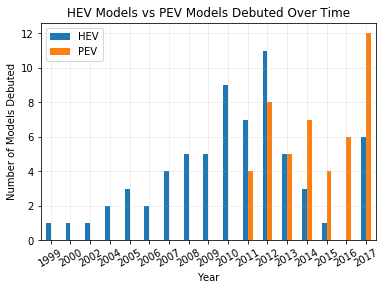

In [14]:
#create the plot showing the debuts of HEV vs PEV models over time

debutYeargb = debutYear.groupby(['Debut', 'Type']).aggregate({"Model":'count'})

fig = debutYeargb.unstack().plot(kind = 'bar', rot = 30)
fig.legend(['HEV','PEV'])
fig.grid(alpha = .25)
fig.set_xlabel('Year')
fig.set_ylabel('Number of Models Debuted')
fig.set_title('HEV Models vs PEV Models Debuted Over Time')
fig = fig.get_figure()
fig.savefig('Plots and Maps\HEV vs PEV Models Debuted')

In [1]:
import numpy as np

In [4]:
hybrid_and_plugin_sales_df = pd.read_excel('Datasets/reduced_table6_02.xlsx', index_col=None)

# hybrid_and_plugin_sales_df

In [5]:
# the first year that we have both hybrid and plug-in vehicle sales: 2010

year_2010_hybrid_sales = hybrid_and_plugin_sales_df.iloc[11, hybrid_and_plugin_sales_df.columns.get_loc('Hybrid sales')]
# print(year_2010_hybrid_sales)
year_2010_plugin_sales = hybrid_and_plugin_sales_df.iloc[11, hybrid_and_plugin_sales_df.columns.get_loc('Plug-in sales')]
# print(year_2010_plugin_sales)
year_2010_all_sales = hybrid_and_plugin_sales_df.iloc[11, hybrid_and_plugin_sales_df.columns.get_loc('All light vehicle sales')]
# print(year_2010_all_sales)

In [6]:
year_2010_other_sales = year_2010_all_sales - year_2010_hybrid_sales - year_2010_plugin_sales
# print(year_2010_other_sales)

In [7]:
year_2010_percentages = [year_2010_hybrid_sales/year_2010_all_sales*100, year_2010_plugin_sales/year_2010_all_sales*100, year_2010_other_sales/year_2010_all_sales*100]

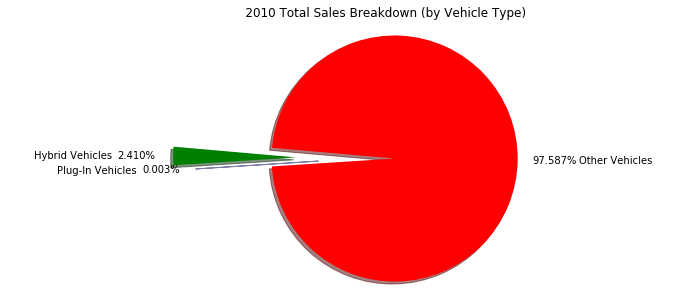

In [8]:
my2010labels = ["Hybrid Vehicles", "Plug-In Vehicles", "Other Vehicles"]

my2010colors = ["green", "blue", "red"]

my2010explode = (0.3, 0.1, 0.5)

plt.figure(figsize=(12, 5))

plt.title("                     2010 Total Sales Breakdown (by Vehicle Type)")
plt.pie(year_2010_percentages, explode=my2010explode, labels=my2010labels, colors=my2010colors,
        autopct="%1.3f%%", pctdistance=1.3, labeldistance=1.5, shadow=True, startangle=175)

# plt.pie(year_2010_percentages, explode=my2010explode, labels=my2010labels, colors=my2010colors,
#         autopct="%1.3f%%", pctdistance=1.3, labeldistance=1.5, shadow=True, startangle=140, wedgeprops={"edgecolor":"k",'linewidth': 2})

plt.axis("equal")

plt.savefig('2010_pie.png')

In [9]:
year_2013_hybrid_sales = hybrid_and_plugin_sales_df.iloc[14, hybrid_and_plugin_sales_df.columns.get_loc('Hybrid sales')]
# print(year_2013_hybrid_sales)
year_2013_plugin_sales = hybrid_and_plugin_sales_df.iloc[14, hybrid_and_plugin_sales_df.columns.get_loc('Plug-in sales')]
# print(year_2013_plugin_sales)
year_2013_all_sales = hybrid_and_plugin_sales_df.iloc[14, hybrid_and_plugin_sales_df.columns.get_loc('All light vehicle sales')]
# print(year_2013_all_sales)

In [10]:
year_2013_other_sales = year_2013_all_sales - year_2013_hybrid_sales - year_2013_plugin_sales
# print(year_2013_other_sales)

In [11]:
year_2013_percentages = [year_2013_hybrid_sales/year_2013_all_sales*100, year_2013_plugin_sales/year_2013_all_sales*100, year_2013_other_sales/year_2013_all_sales*100]

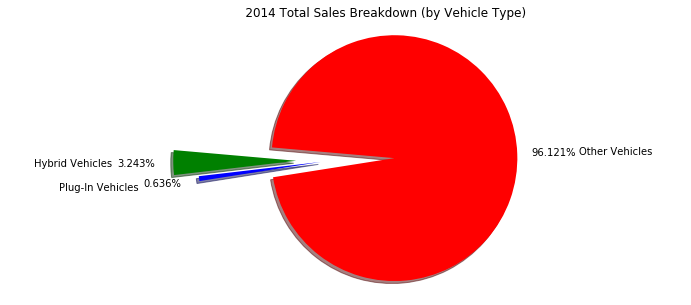

In [12]:
my2013labels = ["Hybrid Vehicles", "Plug-In Vehicles", "Other Vehicles"]

my2013colors = ["green", "blue", "red"]

my2013explode = (0.3, 0.1, 0.5)

plt.figure(figsize=(12, 5))

plt.title("                     2014 Total Sales Breakdown (by Vehicle Type)")
plt.pie(year_2013_percentages, explode=my2013explode, labels=my2013labels, colors=my2013colors,
        autopct="%1.3f%%", pctdistance=1.3, labeldistance=1.5, shadow=True, startangle=175)

plt.axis("equal")

plt.savefig('2013_pie.png')

In [13]:
year_2017_hybrid_sales = hybrid_and_plugin_sales_df.iloc[18, hybrid_and_plugin_sales_df.columns.get_loc('Hybrid sales')]
# print(year_2017_hybrid_sales)
year_2017_plugin_sales = hybrid_and_plugin_sales_df.iloc[18, hybrid_and_plugin_sales_df.columns.get_loc('Plug-in sales')]
# print(year_2017_plugin_sales)
year_2017_all_sales = hybrid_and_plugin_sales_df.iloc[18, hybrid_and_plugin_sales_df.columns.get_loc('All light vehicle sales')]
# print(year_2017_all_sales)

In [14]:
year_2017_other_sales = year_2017_all_sales - year_2017_hybrid_sales - year_2017_plugin_sales
# print(year_2017_other_sales)

In [15]:
year_2017_percentages = [year_2017_hybrid_sales/year_2017_all_sales*100, year_2017_plugin_sales/year_2017_all_sales*100, year_2017_other_sales/year_2017_all_sales*100]

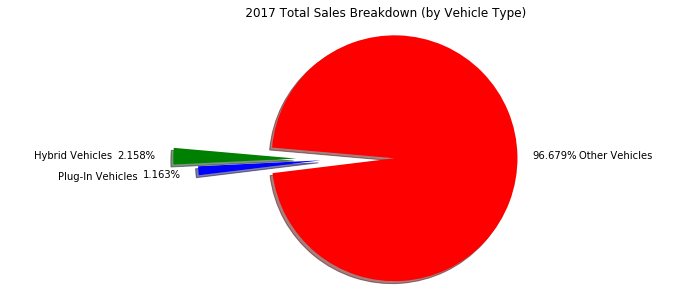

In [16]:
my2017labels = ["Hybrid Vehicles", "Plug-In Vehicles", "Other Vehicles"]

my2017colors = ["green", "blue", "red"]

my2017explode = (0.3, 0.1, 0.5)

plt.figure(figsize=(12, 5))

plt.title("                     2017 Total Sales Breakdown (by Vehicle Type)")
plt.pie(year_2017_percentages, explode=my2017explode, labels=my2017labels, colors=my2017colors,
        autopct="%1.3f%%", pctdistance=1.3, labeldistance=1.5, shadow=True, startangle=175)

plt.axis("equal")

plt.savefig('2017_pie.png')

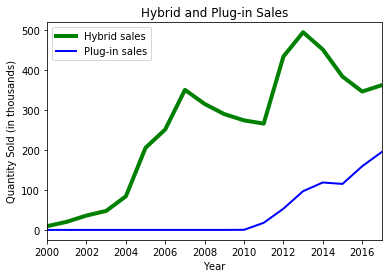

In [17]:
sales_x_values = np.arange(1999, 2018)
plt.plot( sales_x_values, 'Hybrid sales', data=hybrid_and_plugin_sales_df, marker='', markerfacecolor='blue', markersize=12, color='green', linewidth=4)
plt.plot( sales_x_values, 'Plug-in sales', data=hybrid_and_plugin_sales_df, marker='', color='blue', linewidth=2)
plt.legend()
plt.title("Hybrid and Plug-in Sales")
plt.xlabel("Year")
##EC - added xlim to plots to make them the same timespan and round value ticks.
plt.xlim(2000,2017)
plt.ylabel("Quantity Sold (in thousands)")

plt.savefig('sales_trend.png')

In [18]:
gas_prices_df = pd.read_excel('Datasets/reg_retail_gas_prices.xlsx', index_col=None)

# gas_prices_df.head()

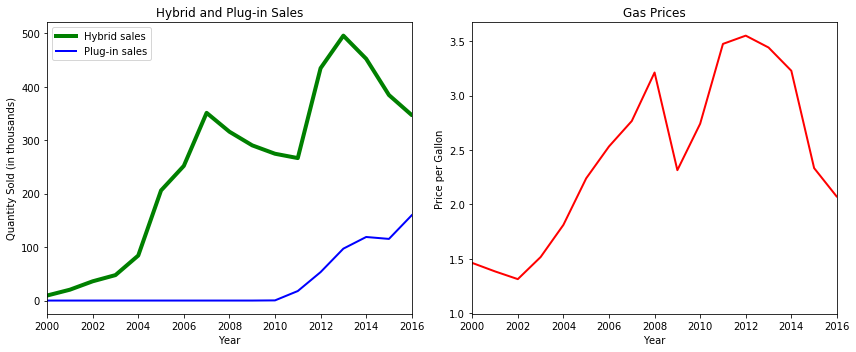

In [19]:
plt.figure(figsize=(12, 5))


##EC - added xlim to plots to make them the same timespan and round value ticks.

plt.subplot(1, 2, 1)
plt.plot( sales_x_values, 'Hybrid sales', data=hybrid_and_plugin_sales_df, marker='', markerfacecolor='blue', markersize=12, color='green', linewidth=4)
plt.plot( sales_x_values, 'Plug-in sales', data=hybrid_and_plugin_sales_df, marker='', color='blue', linewidth=2)
plt.legend()
plt.xlim(2000,2016)
plt.title("Hybrid and Plug-in Sales")
plt.xlabel("Year")
plt.ylabel("Quantity Sold (in thousands)")

plt.subplot(1, 2, 2)
plt.plot( sales_x_values, 'Price', data=gas_prices_df, marker='', color='red', linewidth=2)
plt.title("Gas Prices")
plt.xlabel("Year")
plt.ylabel("Price per Gallon")
plt.xlim(2000,2016)

plt.tight_layout()

plt.savefig('sales_and_gas.png')

In [4]:
#Reading Data for cars
df_car_data = pd.read_csv("Datasets/cardataset.zip")

In [5]:
# Renaming column names by adding '_' 
df_car_data.columns = [c.replace(' ', '_') for c in df_car_data.columns]

In [6]:
df_car_data.drop(df_car_data[df_car_data.highway_MPG == 354].index, inplace=True)

In [7]:
#Categorizing fuel type broadly into premium,diesel,flex-fuel,electric & natural gas
df_car_data.replace(to_replace='premium unleaded (required)', value='Premium', inplace=True)
df_car_data.replace(to_replace='premium unleaded (recommended)', value='Premium', inplace=True)
df_car_data.replace(to_replace='flex-fuel (unleaded/E85)', value='Flex-Fuel', inplace=True)
df_car_data.replace(to_replace='flex-fuel (premium unleaded recommended/E85)', value='Flex-Fuel', inplace=True)
df_car_data.replace(to_replace='flex-fuel (premium unleaded required/E85)', value='Flex-Fuel', inplace=True)
df_car_data.replace(to_replace='flex-fuel (unleaded/natural gas)', value='Flex-Fuel', inplace=True)
df_car_data.replace(to_replace='regular unleaded', value='Regular', inplace=True)
df_car_data.replace(to_replace='diesel', value='Diesel', inplace=True)
df_car_data.replace(to_replace='electric', value='Electric', inplace=True)
df_car_data.replace(to_replace='natural gas', value='Natural Gas', inplace=True)

In [9]:
df_car_data.head(2)

Make       Model  Year Engine_Fuel_Type  Engine_HP  Engine_Cylinders  \
0  BMW  1 Series M  2011          Premium      335.0               6.0   
1  BMW    1 Series  2011          Premium      300.0               6.0   

  Transmission_Type     Driven_Wheels  Number_of_Doors  \
0            MANUAL  rear wheel drive              2.0   
1            MANUAL  rear wheel drive              2.0   

                         Market_Category Vehicle_Size Vehicle_Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         Coupe   
1                     Luxury,Performance      Compact   Convertible   

   highway_MPG  city_mpg  Popularity   MSRP  
0           26        19        3916  46135  
1           28        19        3916  40650

In [11]:
#Reading sales data for cars
df_electric = pd.read_csv("Datasets/Sales.csv")

In [12]:
#Subseting data for electric cars
df_electric = df_electric[df_electric.Type == "EV"]

In [13]:
#creating seperate columns for Make & Model
df_electric['Make'], df_electric['Model'] = df_electric['Model'].str.split(' ', 1).str
#cleaning df_electric 
df_electric = df_electric.drop('Type', 1)
df_electric = pd.melt(df_electric, id_vars=["Model", "Make"], 
                  var_name="Year", value_name="Sales")

In [14]:
# Reanming some model names to merge correctly with our base table(df_car_meta)
df_electric.replace(to_replace='LEAF', value='Leaf', inplace=True)
df_electric.replace(to_replace='Spark', value='Spark EV', inplace=True)
df_electric.replace(to_replace='B-Class Electric', value='B-Class Electric Drive', inplace=True)
df_electric.replace(to_replace='500E', value='500e', inplace=True)
df_electric.replace(to_replace='Focus EV', value='Focus', inplace=True)
df_electric['Sales'] = df_electric['Sales'].str.replace(',', '')

In [15]:
#Subseting df_car_meta just for electric cars
df_electric_info = df_car_data[(df_car_data.Engine_Fuel_Type == 'Electric') ].groupby(['Make', 
                    'Model', 'Year', 'Vehicle_Style', 'Vehicle_Size'], 
                            as_index=False).agg({'highway_MPG': 'mean', 'Popularity': 'sum'})

df_electric_info.sort_values('Year', ascending=True, inplace=True)
df_electric_info['Year'] = df_electric_info['Year'].apply(str)

In [16]:
df_electric_final = df_electric.merge(df_electric_info, on=['Model', 'Year'], how='left')

In [17]:
#converting Sales column to int for future calculations
df_electric_final['Sales'] = df_electric_final['Sales'].astype(str).astype(int)
df_electric_final = df_electric_final[df_electric_final.Sales != 0]

In [18]:
df_electric_sales_plot = df_electric_final.groupby(['Make_x', 'Year'], as_index=False).agg({'Sales': 'sum'})
df_electric_sales_plot = df_electric_sales_plot.pivot_table('Sales', ['Year'], 'Make_x')
df_electric_sales_plot.reset_index(inplace = True)
df_electric_sales_plot = df_electric_sales_plot.fillna(0)
df_electric_sales_plot['Other'] = df_electric_sales_plot.Chevrolet + df_electric_sales_plot.Fiat + df_electric_sales_plot.Ford + df_electric_sales_plot.Honda + df_electric_sales_plot.Kia + df_electric_sales_plot.Mercedes + df_electric_sales_plot.Mitsubishi + df_electric_sales_plot.Smart + df_electric_sales_plot.Toyota + df_electric_sales_plot.VW

In [19]:
trace1 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Chevrolet,
    name='Chevrolet',
    
)
trace2 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Toyota,
    name='Toyota',
)

trace3 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Fiat,
    name='Fiat',
)

trace4 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Ford,
    name='Ford',
)


trace5 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Honda,
    name='Honda',
)

trace6 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Kia,
    name='Kia',
)
trace7 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Mercedes,
    name='Mercedes',
)
trace8 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.VW,
    name='VW',
)
trace9 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Mitsubishi,
    name='Mitsubishi',
)

trace10 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Nissan,
    name='Nissan',
)

trace11 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Tesla,
    name='Tesla',
)
trace12 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.BMW,
    name='BMW')


data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace11, trace12]

layout = go.Layout(
         barmode='stack',
         title='Electric Car Sales',
         autosize=False,
         width=900,
         height=500,
    font=dict(family='Arial', size=20, color='black'),
    xaxis=dict(
               showgrid=True,
               gridwidth=2,
               title='Year',
               titlefont=dict(
               family='Arial',
               size=18,
               color='black'),
               dtick=1,
               tickfont=dict(
                        family='Arial',
                        size=14,
                        color='black')),
   
    yaxis=dict(
               showgrid=True,
               gridwidth=2,
               ticklen=1,
               title='Sale in Thousands',
               titlefont=dict(
               family='Arial',
               size=18,
               color='black'),
                tickfont=dict(
                        family='Arial',
                        size=14,
                        color='black')))
fig = go.Figure(data = data, layout = layout)
iplot(fig);

NameError: name 'go' is not defined

In [20]:
trace1 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Other,
    name='Other',
    marker = dict(color = "#A9A9A9")
)

trace2 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Nissan,
    name='Nissan',
    marker = dict(color = "#0A9CC3")
)

trace3 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.Tesla,
    name='Tesla',
    marker = dict(color = "#456990")
)
trace4 = go.Bar(
    x=df_electric_sales_plot.Year,
    y=df_electric_sales_plot.BMW,
    name='BMW',
    marker = dict(color = "#C7DB67"))

data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
         barmode='stack',
         title='Electric Car Sales',
         autosize=False,
         width=900,
         height=700,
    font=dict(family='Arial', size=20, color='black'),
    xaxis=dict(
               showgrid=True,
               gridwidth=2,
               title='Year',
               titlefont=dict(
               family='Arial',
               size=18,
               color='black'),
               dtick=1,
               tickfont=dict(
                        family='Arial',
                        size=16,
                        color='black')),
   
    yaxis=dict(
               showgrid=True,
               gridwidth=2,
               ticklen=1,
               title='Sale in Thousands',
               titlefont=dict(
               family='Arial',
               size=18,
               color='black'),
                tickfont=dict(
                        family='Arial',
                        size=16,
                        color='black')))
fig = go.Figure(data = data, layout = layout)
iplot(fig);

NameError: name 'go' is not defined